In [11]:
'''
## 共享GPU
import tensorflow as tf
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.25)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)) 
'''

'\n## 共享GPU\nimport tensorflow as tf\ngpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.25)\nsess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)) \n'

In [12]:
from keras.layers import Activation, Conv2D, BatchNormalization, Dense,add
from keras.layers import Dropout, Flatten, Input, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras import Model 
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

In [13]:
# 读取训练集与验证集
IMSIZE = 224
train_generator = ImageDataGenerator(rescale=1./225).flow_from_directory('/mnt/data/data_res/train',
                                                                        target_size=(IMSIZE,IMSIZE),
                                                                        batch_size=64,
                                                                        class_mode='categorical')

validation_generator = ImageDataGenerator(rescale=1./225).flow_from_directory('/mnt/data/data_res/validation',
                                                                        target_size=(IMSIZE,IMSIZE),
                                                                        batch_size=64,
                                                                        class_mode='categorical')


Found 1612 images belonging to 3 classes.
Found 355 images belonging to 3 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

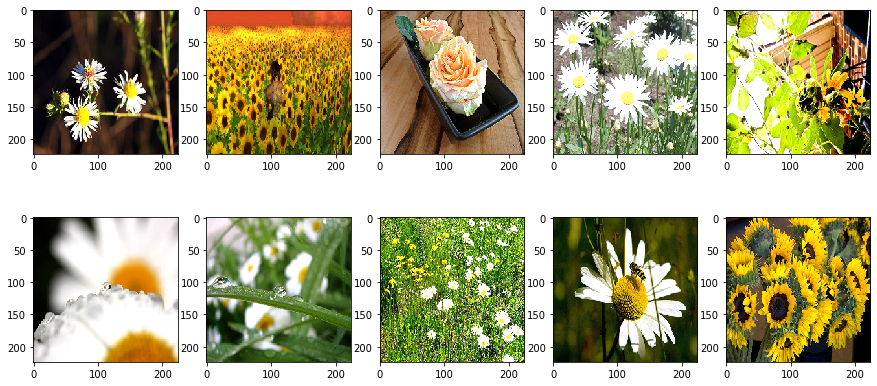

In [14]:
plt.figure()
fig, ax = plt.subplots(2,5)
fig.set_figheight(7)
fig.set_figwidth(15)
ax = ax.flatten()
X, Y = next(validation_generator)
for i in range(10):
    ax[i].imshow(X[i,:,:,:])
plt.show()

In [15]:
#构造残差学习模块之前的网络结构
NB_CLASS = 3
IM_WIDTH = 224
IM_HEIGHT = 224
input_layer = Input(shape=(IM_WIDTH,IM_HEIGHT,3))
x = Conv2D(64,[7,7],padding='same',strides=(2,2))(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(3,3),strides=[2,2],padding='same')(x)
x0 = x

#一个残差模块
x = Conv2D(64,[1,1],padding='same',strides=(1,1))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64,[3,3],padding='same',strides=(1,1))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(256,[1,1],padding='same',strides=(1,1),activation=None)(x)
x = BatchNormalization()(x)

#让x0和x维数相同，可以进行加法计算
x0 = Conv2D(256,[1,1],padding='same',strides=(1,1))(x0)
x0 = BatchNormalization()(x0)
x0 = Activation('relu')(x0)
x = add([x,x0])
x = Activation('relu')(x)
x0 = x

#主题模型结构展示
x = Flatten()(x)
x = Dense(NB_CLASS,activation='softmax')(x)
output_layer = x
model=Model(input_layer,x)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 112, 112, 64) 256         conv2d_6[0][0]                   
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 112, 112, 64) 0           batch_normalization_6[0][0]      
____________________________________________________________________________________________

In [17]:
#ResNet编译运行
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
model.fit_generator(train_generator,epochs=10,validation_data=validation_generator,validation_steps=100)

Epoch 1/10
26/26 [==============================] - 101s 4s/step - loss: 25.9288 - accuracy: 0.8027 - val_loss: 22.3317 - val_accuracy: 0.7156
Epoch 2/10
26/26 [==============================] - 31s 1s/step - loss: 8.0098 - accuracy: 0.8952 - val_loss: 15.3058 - val_accuracy: 0.6783
Epoch 3/10
26/26 [==============================] - 30s 1s/step - loss: 6.1556 - accuracy: 0.9094 - val_loss: 18.0973 - val_accuracy: 0.7171
Epoch 4/10
26/26 [==============================] - 30s 1s/step - loss: 1.5086 - accuracy: 0.9603 - val_loss: 11.1331 - val_accuracy: 0.6885
Epoch 5/10
26/26 [==============================] - 30s 1s/step - loss: 1.6206 - accuracy: 0.9609 - val_loss: 15.0620 - val_accuracy: 0.6892
Epoch 6/10
26/26 [==============================] - 30s 1s/step - loss: 1.4428 - accuracy: 0.9702 - val_loss: 48.6528 - val_accuracy: 0.7417
Epoch 7/10
26/26 [==============================] - 30s 1s/step - loss: 4.3389 - accuracy: 0.9305 - val_loss: 32.9633 - val_accuracy: 0.8138
Epoch 8/10
